# TIME-DELAY DIFFERENTIAL EQUATIONS

### A piece of art by Valentin Zulkower

## Code

In [1]:
%matplotlib inline
import scipy.integrate
import scipy.interpolate

class ddeVar:

    def __init__(self,g,tc=0):
        """ g(t) = expression of Y(t) for t<tc """
        self.g = g
        self.tc= tc
        # We must fill the interpolator with 2 points minimum
        self.itpr = scipy.interpolate.interp1d(
            np.array([tc-1,tc]), # X
            np.array([self.g(tc),self.g(tc)]).T, # Y
            kind='linear', bounds_error=False,
            fill_value = self.g(tc))
        
    def update(self,t,Y):
        """ Add one new (ti,yi) to the interpolator """
        self.itpr.x = np.hstack([self.itpr.x, [t]])
        Y2 = Y if (Y.size==1) else np.array([Y]).T
        self.itpr.y = np.hstack([self.itpr.y, Y2])
        self.itpr.fill_value = Y

    def __call__(self,t=0):
        """ Y(t) will return the instance's value at time t """
        return (self.g(t) if (t<=self.tc) else self.itpr(t))
    

class dde(scipy.integrate.ode):
    """ Overwrites a few functions of scipy.integrate.ode"""

    def __init__(self,f,jac=None):
        def f2(t,y,args):
            return f(self.Y,t,*args)
        scipy.integrate.ode.__init__(self,f2,jac)
        self.set_f_params(None)

    def integrate(self, t, step=0, relax=0):
        scipy.integrate.ode.integrate(self,t,step,relax)
        self.Y.update(self.t,self.y)
        return self.y

    def set_initial_value(self,Y):
        self.Y = Y #!!! Y will be modified during integration
        scipy.integrate.ode.set_initial_value(self, Y(Y.tc), Y.tc)

    
    
def ddeint(func,g,tt,fargs=[]):
    """ similar to scipy.integrate.odeint. Solves the DDE system
        defined by func at the times tt with initial conditions
        y0 and potential additional arguments for the model, fargs
    """
    dde_ = dde(func)
    dde_.set_initial_value(ddeVar(g,tt[0]))
    dde_.set_f_params(fargs)
    return np.array([g(tt[0])]+[dde_.integrate(dde_.t + dt)
                                 for dt in np.diff(tt)])

## Example 1 : Sin

$y(t) = sin(t)$, pour $t < 0$

$y'(t) = y(t-3\pi/2)$, pour $t \geq 0$

solution exacte : $sin(t)$

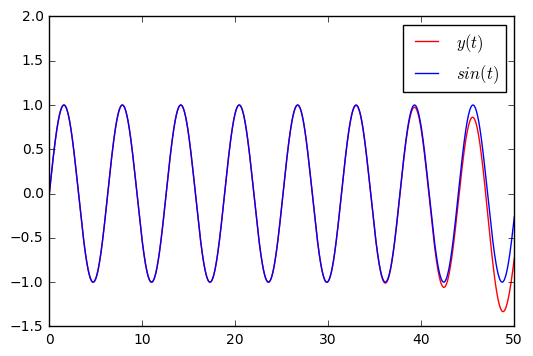

In [2]:
from pylab import *

model = lambda Y,t : Y(t - 3*pi/2) # MODEL
tt = linspace(0,50,10000) # TIME RESOLUTION
g=sin # Expression of Y(t) before the integration interval 
yy = ddeint(model,g,tt) # SOLVING

# PLOTTING
fig,ax=subplots(1)
ax.plot(tt,yy,c='r',label="$y(t)$")
ax.plot(tt,sin(tt),c='b',label="$sin(t)$")
ax.set_ylim(ymax=2) # make room for the legend
ax.legend()
fig.savefig('dde_sin.png')
show()


## Example 2 : Delayed negative feedback

$y(t) = 0$, pour $t < 0 $

$ y'(t) = \dfrac{1}{1+(\dfrac{y(t-d)}{K})^2} -y(t)$, pour $t \geq 0$

solution : oscillations

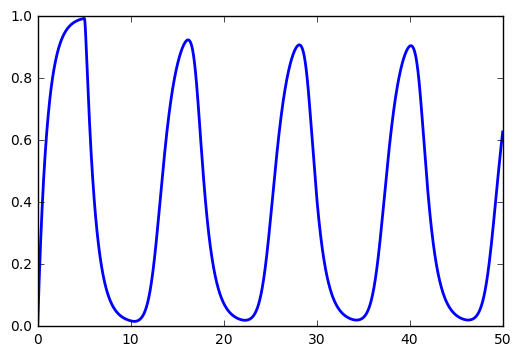

In [3]:
from pylab import *

# MODEL
model = lambda Y,t,k,d,r :  1/(1+(Y(t-d)/k)**2) - r*Y(t)

# HISTORY
g = lambda t:0 

# SOLVING
tt = linspace(0,50,10000)
yy = ddeint(model,g,tt,fargs=(0.1,5,1))

# PLOTTING
fig,ax=subplots(1)
ax.plot(tt,yy,lw=2)
show()
fig.savefig('dde_negativefeedback')

## Example 3 : vectors : lotka-volterra

IndexError: index 2 is out of bounds for axis 0 with size 2

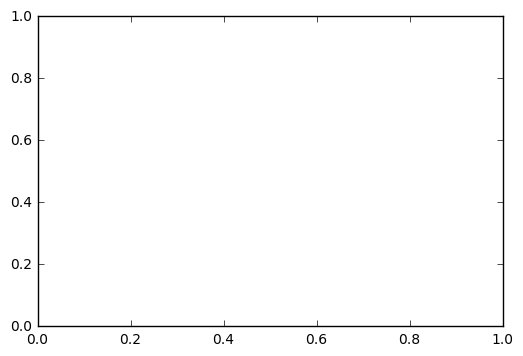

In [4]:
from pylab import *

def model(Y,t,d):
    x,y = Y(t)
    xd,yd = Y(t-d)
    return np.array([0.5*x*(1-yd), -0.5*y*(1-xd)])

g = lambda t : np.array([1,2])
tt = linspace(2,30,20000)
fig,ax=subplots(1)

for d in [0, 0.2]:
    yy = ddeint(model,g,tt,fargs=(d,))
    ax.plot(yy[:,0],yy[:,1],lw=2,label='delay = %.01f'%d)

ax.legend()
show()
fig.savefig('dde_lotka.png')

## Example 4: Y-dependent delay

$y(t) = 0,\ \ \ t<0$

$y'(t) = y\big(t-3\cos(y(t))^2 \big) $

In [ ]:
from pylab import *
model = lambda Y,t:  -Y(t-3*cos(Y(t))**2)
tt = linspace(0,30,2000)
yy = ddeint(model, lambda t:1, tt)
fig,ax=subplots(1)
ax.plot(tt,yy,lw=2)
show()
fig.savefig('dde_Ydependent.png')

In [4]:
tt


array([  0.00000000e+00,   5.00050005e-03,   1.00010001e-02, ...,
         4.99899990e+01,   4.99949995e+01,   5.00000000e+01])

In [5]:
length(tt)

NameError: name 'length' is not defined

In [6]:
len(tt)

10000

In [7]:
yy

NameError: name 'yy' is not defined

In [8]:
len(diff(tt))

9999

In [9]:
[dt for dt in range(5)]

[0, 1, 2, 3, 4]

In [10]:
[3]+[dt for dt in range(5)]

[3, 0, 1, 2, 3, 4]